$s$: CARを計算できたPRの文書集合、$s_1 (\subset s)$: CARが高かったPRの文書集合、$s_2 (:= s - s_1)$: CARが高くなかったPRの文書集合とする。

単語$t$に対して、tf-idf値を以下のように定義。

$$
{\rm tf}(t, s_1) = \frac{df(t, s_1)}{|s_1|}
$$

$$
{\rm idf}(t) = \log\frac{|s|}{df(t,s)}
$$

$$
{\rm df}(t, x) = \left|\{d\mid d\ni t, d\in x\}\right|
$$

$$
{\rm tf}\cdot{\rm idf}(t, s_1) = {\rm tf}(t, s_1)\cdot {\rm idf}(t)
$$

tf-idfが高い単語から並べる。

tf-idf(w, s_1) ~ (# of PRs with w in s_1) / (# of PRs with w in s)

tf-idf ~ 0 <=> w is enriched only in s

tf-idf ~ 1 <=> w is enriched only in s_1

**NOTE: 実際の計算は Jupyter が multiprocessing の生成するプロセスを殺せないためここだと時間がかかり過ぎてしまうので、ここには小さいデータでの実行例を示して、全体のデータは同じコードで別の場所で計算している。**

In [1]:
## 入力データのファイル名
pr_mor_fname = "../fix_input_data/hoge.csv.mor"#pressrelease_all_normalized.csv.mor"   # MeCab で形態素に分解済みのプレスリリース本文
car_sig_fname = "car_exactT_alpha0.1_sig"
car_not_sig_fname = "car_exactT_alpha0.1_not_sig"

In [2]:
## import
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
from scipy import stats
from multiprocessing import Pool
from collections import Counter

## データの読み込み

In [3]:
## CAR。tf-idf 計算は、car_sig と car_all = car_sig + car_not_sig の間で行う
## CAR が計算できたものだけを取り扱う点、PR ごとに CAR の平均値を取らない点(後述)が前回と異なる。

car_sig = pd.read_table(car_sig_fname, sep = '\t')   # 有意なもの
car_not_sig = pd.read_table(car_not_sig_fname, sep = '\t')   # 有意でないもの
car_sig[0:3]

,article_id,pr_type,comp_code,car,t_stat
0,NIKPRLRSP040809_18022003,01: Product,2593,0.079042,1.582459
1,NIKPRLRSP045017_21042003,04: Alliance,7599,0.120927,1.583770
2,NIKPRLRSP050445_10072003,01: Product,7911,0.104491,2.325275


In [4]:
id_set_sig = set(car_sig["article_id"])   # 一番上の s_1 (の ID)に対応する
id_set_not_sig = set(car_not_sig["article_id"])
id_set_all = id_set_sig.union(id_set_not_sig)   # s (の ID)に対応する

num_sig = len(id_set_sig)   # | s_1 | に対応する
num_all = len(id_set_all)   # | s | に対応する
print(num_sig, len(id_set_not_sig), len(id_set_sig.intersection(id_set_not_sig)), num_all)

706 24397 108 24995


-> 有意な CAR を持つ PR 706個のうち、108個が有意でない(他の企業とのマッチングによる) CAR も同時に持っている

TODO: これの扱い (現在は有意な PR に含めている; PR ごとに CAR の平均を取ること(前回はこれを採用していた)はしたくない)

In [5]:
## PR本文の分かち書き。pd.read_table は OutOuMemory で落ちてしまったので、1行ごとに追加する

pr_mor = pd.DataFrame()
with open(pr_mor_fname, 'r') as f:
    for line in f:
        article_id, mor = line.strip().split('\t')
        if article_id in id_set_all:
            pr_mor = pr_mor.append([[article_id, mor]], ignore_index = True)
pr_mor.columns = ["article_id", "pr_mor"]

## df, idf, tf, tf-idf の計算

In [6]:
pr_sig = pr_mor[[x in id_set_sig for x in list(pr_mor["article_id"])]]   # s_1 に含まれるプレスリリース
pr_all = pr_mor[[x in id_set_all for x in list(pr_mor["article_id"])]]   # s に含まれるプレスリリース

In [7]:
pr_as_word_set_sig = [set(x.split(' ')) for x in list(pr_sig["pr_mor"])]   # [set(words in PR in s_1)]
pr_as_word_set_all = [set(x.split(' ')) for x in list(pr_all["pr_mor"])]   # [set(words in PR in s)]

In [8]:
word_count = Counter()
for mor in list(pr_all["pr_mor"]):
    for w in mor.split(' '):
        word_count[w] += 1
        
## TODO: 単語の純粋な出現回数ではなく、出現したPRの数でフィルターするべき？

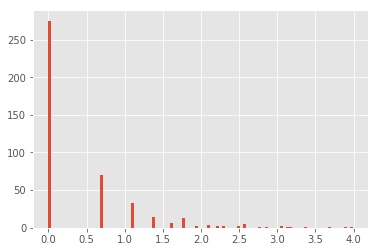

In [9]:
ret = plt.hist(list(map(math.log, list(word_count.values()))), bins = 100)   # 対数プロット

In [10]:
max_count = 1000000   # very sensitive for input data
min_count = 0   # very sensitive for input data

words = set()   # filtered set of words to be used for tf-idf calculation
for w, c in word_count.items():
    if min_count <= c and c <= max_count:
        words.add(w)

In [11]:
def calc_pr_num_with_word_in_sig(word):   # s1 のうち word を含む PR の数
    count = 0
    for mor in pr_as_word_set_sig:
        if word in mor:
            count += 1
    return (word, count)

def calc_pr_num_with_word_in_all(word):   # s のうち word を含む PR の数
    count = 0
    for mor in pr_as_word_set_all:
        if word in mor:
            count += 1
    return (word, count)

In [12]:
exe_pool = Pool(7)
df_sig = Counter()
for ret in exe_pool.imap(calc_pr_num_with_word_in_sig, words):
    df_sig[ret[0]] = ret[1]

In [13]:
list(df_sig.items())[0:10]

[('苦渋', 1),
 ('含む', 1),
 ('『', 0),
 ('101', 1),
 ('創造', 1),
 ('現在', 0),
 ('サイト', 0),
 ('自然', 1),
 ('する', 1),
 ('昭和56年', 1)]

In [14]:
exe_pool = Pool(7)
df_all = Counter()
for ret in exe_pool.imap(calc_pr_num_with_word_in_all, words):
    df_all[ret[0]] = ret[1]

In [15]:
list(df_all.items())[0:10]

[('苦渋', 1),
 ('含む', 1),
 ('『', 1),
 ('101', 1),
 ('創造', 1),
 ('現在', 1),
 ('サイト', 1),
 ('自然', 1),
 ('する', 2),
 ('昭和56年', 1)]

In [47]:
tfidf = pd.DataFrame()
for w in words:
    tfidf_value = float(df_sig[w]) / num_sig * math.log(float(num_all) / df_all[w], 2)
    tfidf = tfidf.append([[w, tfidf_value, df_all[w], num_all - df_all[w], df_sig[w], num_sig - df_sig[w]]], ignore_index = True)
tfidf.columns = ["word", "tf-idf", "df_all", "num_all - df_all", "df_sig", "num_sig - df_sig"]
tfidf = tfidf.sort_values('tf-idf', ascending = False)

In [50]:
tfidf[0:10]
## 検定は odds_ratio, p_value = stats.fisher_exact(count_table) で行う。全部の検定は時間がかかるのでここでは行わず、後でトップの単語から順に調べる

,word,tf-idf,df_all,num_all - df_all,df_sig,num_sig - df_sig
0,苦渋,0.020693,1,24994,1,705
248,高温,0.020693,1,24994,1,705
216,抑え,0.020693,1,24994,1,705
1,含む,0.020693,1,24994,1,705
221,世界初,0.020693,1,24994,1,705
222,10%,0.020693,1,24994,1,705
225,伊藤園,0.020693,1,24994,1,705
226,itoen,0.020693,1,24994,1,705
228,せんち,0.020693,1,24994,1,705
229,‐,0.020693,1,24994,1,705


In [52]:
tfidf.to_csv(car_sig_fname + ".tfidf", sep = "\t", index = False)

In [54]:
stats.fisher_exact([[5187, 19808], [217, 489]])

(0.59009881963624988, 9.1373036860160061e-10)

In [55]:
stats.fisher_exact([[4790, 20205], [163, 543]])

(0.78974863477575707, 0.010312445458394392)

In [57]:
stats.fisher_exact([[5816, 19179], [177, 529]])

(0.9063184986639401, 0.25959478624289356)

## TODO: sig の中でさらに分割してtf-idf

In [53]:
## TODO: TF-IDF の定義を見直す、s_1 と s_2 の間のカイ二乗検定とどう違ってくるのか？